In [1]:
# !pip install --upgrade transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00


In [2]:
#Import package
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# function to seed the script globally
torch.manual_seed(0)
#nltk 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


#transformers 
from transformers import (
    BertForSequenceClassification,
     TFBertForSequenceClassification, 
                          BertTokenizer,
                           TFRobertaForSequenceClassification,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                          AutoTokenizer, XLNetForSequenceClassification,
                         AdamW)
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification, Trainer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# mount
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Challenge_INF582/")

We will follow the procedure detailed below:
1. Installing required dependencies
2. Loading both Fake and Real news data
3. Preprocess the text - Data Cleaning & Standardisation
4. Initiatizing pretrained models - BERT & RoBERTa
5. Tokenzie this dataset so that it can be used by the model
6. Train and Test split
7. Set-up a training loop; train the model on the training data
8. Evaluate the model on the testing data by comparing to the actual results

## Set device to GPU

In [ ]:
# set device
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


#### 2. Load Data

In [ ]:
train_df = pd.read_json('./train_set.json')
test_df = pd.read_json('./test_set.json')
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print('Number of testing sentences: {:,}\n'.format(test_df.shape[0]))

Number of training sentences: 4,000

Number of testing sentences: 4,000



### 3. Pre-processing Text

In [ ]:
# view text before preprocess
train_df['text'].head()

0    Remains dating to the 5th century were found i...
1    Professional Identification is a type of socia...
2    A magistrate has refused a media ban on the tr...
3    The Conservation Commons is the expression of ...
4    Myer is holding a 75 per cent of designer labe...
Name: text, dtype: object

In [ ]:
# # Define the split function
# def split(text):
#     split_index = int(len(text)/3)
#     part1 = text[:split_index]
#     part2 = text[split_index:2*split_index]
#     part3 = text[2*split_index:]
#     return part1, part2, part3

# # Apply the split function to each row of the dataframe
# train_df[['subtext1', 'subtext2','subtext3']] = train_df['text'].apply(split).apply(pd.Series)
# train_df = train_df.drop(columns='text',axis=1)
# df2 = train_df[['label', 'subtext2']].rename(columns={'subtext2': 'text'})
# df3 = train_df[['label', 'subtext1']].rename(columns={'subtext1': 'text'})
# df4 = train_df[['label', 'subtext3']].rename(columns={'subtext3': 'text'})
# train_df = pd.concat([df2, df3,df4], ignore_index=True)

In [ ]:
# print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

In [ ]:
# # # Check if any value in the dataframe is None
# # if train_df.isnull().values.any():
# #     print("Dataframe contains None values")
#       # Drop rows with any None value
#       train_df.dropna(inplace=True)
# # else:
# #     print("Dataframe does not contain None values")

In [ ]:
# import re
# def clean_text(text):
#     text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
#     text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
#     text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
#     text = re.sub('\t', ' ',  text)
#     text = re.sub(r" +", ' ', text)
#     stop_words = set(stopwords.words('english'))
#     text_tokens = text.split()
#     text = ' '.join([word for word in text_tokens if not word.lower() in stop_words])
#     return text

In [ ]:
# train_df['text'] = train_df['text'].apply(clean_text)
# test_df['text'] = test_df['text'].apply(clean_text)

In [ ]:
# Get the lists of train sentences and train labels
sentences = train_df['text'].values
labels = train_df['label'].values

In [ ]:
train_df.head()

,id,text,label
0,0,Remains dating to the 5th century were found i...,1
1,1,Professional Identification is a type of socia...,1
2,2,A magistrate has refused a media ban on the tr...,1
3,3,The Conservation Commons is the expression of ...,1
4,4,Myer is holding a 75 per cent of designer labe...,0


### 4. Initializing the pre-trained models


In [ ]:
# load BERT pre-trained model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
                                                                num_labels = 2, # The number of output labels--2 for binary classification.  
                                                                output_attentions = False, # Whether the model returns attentions weights.
                                                                output_hidden_states = False # Whether the model returns all hidden-states.
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tell pytorch to run this model on the GPU.
bert_model.to(device)
# RoBERTa
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                                    output_attentions = False, # Whether the model returns attentions weights.
                                                                    output_hidden_states = False # Whether the model returns all hidden-states.
                                                                )
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tell pytorch to run this model on the GPU.
roberta_model.to(device)
#XLNet
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",
                                                             num_labels = 2, # The number of output labels--2 for binary classification.
                                                            output_attentions = False, # Whether the model returns attentions weights.
                                                            output_hidden_states = False # Whether the model returns all hidden-states.
                                                             )
xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
xlnet_model.to(device)
print(' Base models loaded')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

 Base models loaded


### 5. Tokenization

In [ ]:
# Print the original sentence.
print('Original sentences: ', sentences[0])
# Print the tweet split into tokens and tokens_id of BERT
print('Tokenized BERT: ', bert_tokenizer.tokenize(sentences[0]))
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))
# Print the tweet split into tokens and tokens_id of RoBERRTa
print('Tokenized RoBERTa: ', roberta_tokenizer.tokenize(sentences[0]))
print('Token IDs RoBERTa: ', roberta_tokenizer.convert_tokens_to_ids(roberta_tokenizer.tokenize(sentences[0])))
# Print the tweet split into tokens and tokens_id of XLNet
print('Tokenized XLNet: ', xlnet_tokenizer.tokenize(sentences[0]))
print('Token IDs XLNet: ', xlnet_tokenizer.convert_tokens_to_ids(xlnet_tokenizer.tokenize(sentences[0])))

Original sentences:  Remains dating to the 5th century were found in tomb in Hwangnam-dong . Show a man 's bones on top of a woman 's who was buried with jewellery . Experts believe Silla Dynasty-era tomb was built for a noblewoman and her lover or bodyguard was sacrificed and buried on top of her . There 's a suggestion that the set-up may have been designed to show two people having sex - and the Silla were known for their explicit pottery .
Tokenized BERT:  ['remains', 'dating', 'to', 'the', '5th', 'century', 'were', 'found', 'in', 'tomb', 'in', 'h', '##wang', '##nam', '-', 'dong', '.', 'show', 'a', 'man', "'", 's', 'bones', 'on', 'top', 'of', 'a', 'woman', "'", 's', 'who', 'was', 'buried', 'with', 'jewellery', '.', 'experts', 'believe', 'si', '##lla', 'dynasty', '-', 'era', 'tomb', 'was', 'built', 'for', 'a', 'noble', '##woman', 'and', 'her', 'lover', 'or', 'bodyguard', 'was', 'sacrificed', 'and', 'buried', 'on', 'top', 'of', 'her', '.', 'there', "'", 's', 'a', 'suggestion', 'that'

In [ ]:
# Tokenize all train sentences
max_len_bert = 0
max_len_roberta = 0
max_len_xlnet = 0
# loop over sentences to tokenize all sentences 
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)
    input_ids_xlnet = xlnet_tokenizer.encode(sent,add_special_tokens=True)
    # Update the maximum sentence length.
    max_len_bert = max(max_len_bert, len(input_ids_bert))
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))
    max_len_xlnet = max(max_len_xlnet, len(input_ids_xlnet))
print('Max sentence length BERT: ', max_len_bert)
print('Max sentence length RoBERTa: ', max_len_roberta)
print('Max sentence length XLNet: ', max_len_xlnet)

Token indices sequence length is longer than the specified maximum sequence length for this model (740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors


Max sentence length BERT:  830
Max sentence length RoBERTa:  807
Max sentence length XLNet:  978


Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
6. The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
bert_input_ids = []
bert_attention_masks = []
roberta_input_ids = []
roberta_attention_masks = []
xlnet_input_ids = []
xlnet_attention_masks = []
sentence_ids = []
counter = 0
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    
    # tokenize for bert
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    #tokenize for roberta
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    xlnet_encoded_dict = xlnet_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    xlnet_input_ids.append(xlnet_encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    xlnet_attention_masks.append(xlnet_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)

xlnet_input_ids = torch.cat(xlnet_input_ids, dim=0)
xlnet_attention_masks = torch.cat(xlnet_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

print('Data is tokenized!!!!')
# Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[1])
# print('Token IDs BERT:', bert_input_ids[1])
# print('Token IDs RoBERTa:', roberta_input_ids[1])
# print('Token IDs XLNet:', xlnet_input_ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Data is tokenized!!!!


### 6. Training & Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)
roberta_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)
xlnet_dataset = TensorDataset(xlnet_input_ids, xlnet_attention_masks, labels)

In [ ]:
# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
# check
trial_dataset =  index_remover(bert_dataset)
trial_dataset[0]
# yes we were able to remove the sentence id from the data without disturbing the data format

(tensor([  101,  3464,  5306,  2000,  1996,  4833,  2301,  2020,  2179,  1999,
          8136,  1999,  1044, 16600, 13129,  1011, 11947,  1012,  2265,  1037,
          2158,  1005,  1055,  5944,  2006,  2327,  1997,  1037,  2450,  1005,
          1055,  2040,  2001,  3950,  2007, 21545,  1012,  8519,  2903,  9033,
          4571,  5321,  1011,  3690,  8136,  2001,  2328,  2005,  1037,  7015,
         10169,  1998,  2014,  7089,  2030, 16174,  2001, 20268,  1998,  3950,
          2006,  2327,  1997,  2014,  1012,  2045,  1005,  1055,  1037, 10293,
          2008,  1996,  2275,  1011,  2039,  2089,  2031,  2042,  2881,  2000,
          2265,  2048,  2111,  2383,  3348,  1011,  1998,  1996,  9033,  4571,
          2020,  2124,  2005,  2037, 13216, 11378,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])
roberta_train_dataset, roberta_val_dataset = random_split(roberta_dataset, [train_size, val_size])
xlnet_train_dataset, xlnet_val_dataset = random_split(xlnet_dataset, [train_size, val_size])
# Checking whether the distribution of target is consitent across both the sets
sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
  sentence_ids_list_valid.append(a.tolist())

# removing sentence ids from tensor dataset so that it can be used for training 
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)



# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in bert_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with AI generated text'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in bert_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with AI generated text'.format(sum(label_temp_list)))

3,600 training samples
1,812 training samples with AI generated text
  400 validation samples
  204 validation samples with AI generated text


### Data Loader

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
)
xlnet_train_dataloader = DataLoader(
            xlnet_train_dataset,  # The training samples.
            sampler = RandomSampler(xlnet_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
)


# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
xlnet_validation_dataloader = DataLoader(
            xlnet_val_dataset, # The validation samples.
            sampler = SequentialSampler(xlnet_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Browse our model:

The embedding layer.
The first of the twelve transformers.
The output layer

In [ ]:
# Get all of the model's parameters as a list of tuples.
# params = list(bert_model.named_parameters())
params = list(roberta_model.named_parameters())
# params = list(xlnet_model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

### 7. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values :

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
We chose:

Batch size: 32 (set when creating our DataLoaders)
Learning rate: 2e-5
Epochs: 4 (we'll see that this is probably too many...)
The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"

In [ ]:
param_optimizer1 = list(bert_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters1 = [
    {'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
param_optimizer2 = list(roberta_model.named_parameters())
optimizer_grouped_parameters2 = [
    {'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
param_optimizer3 = list(xlnet_model.named_parameters())
optimizer_grouped_parameters3 = [
    {'params': [p for n, p in param_optimizer3 if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer3 if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
bert_optimizer = AdamW(optimizer_grouped_parameters1,
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
roberta_optimizer = AdamW(optimizer_grouped_parameters2,
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
xlnet_optimizer = AdamW(optimizer_grouped_parameters3,
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs
# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
xlnet_scheduler = get_linear_schedule_with_warmup(xlnet_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 8. Training Loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### XLNet

In [ ]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

xlnet_training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    xlnet_model.train()
    # For each batch of training data...
    for step, batch in enumerate(xlnet_train_dataloader):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        xlnet_model.zero_grad()        
        output = xlnet_model(b_input_ids, 
#                              token_type_ids=None, 
                            #  attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(xlnet_model.parameters(), 1.0)
        xlnet_optimizer.step()
        xlnet_scheduler.step()
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(xlnet_train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    xlnet_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in xlnet_validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():       
            output = xlnet_model(b_input_ids, 
#                              token_type_ids=None, 
                            #  attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = output.loss
            logits = output.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(xlnet_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(xlnet_validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    xlnet_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.44
  Validation took: 0:00:03

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.36
  Training epcoh took: 0:01:19

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.34
  Validation took: 0:00:03

Training complete!
Total training took 0:02:48 (h:mm:ss)


#### 8.1 BERT

In [ ]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

bert_training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        bert_model.zero_grad()       
        output = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        bert_scheduler.step()
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(bert_train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    bert_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            output = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = output.loss
            logits = output.logits       
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.43
  Validation took: 0:00:02

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.26
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.59
  Validation took: 0:00:02

Training complete!
Total training took 0:01:56 (h:mm:ss)


#### 8.2 RoBERTa

In [ ]:
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

roberta_training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_train_loss = 0
    roberta_model.train()
    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        roberta_model.zero_grad()        
        output = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        roberta_optimizer.step()
        roberta_scheduler.step()
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(roberta_train_dataloader)            
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    roberta_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():       
            output = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
            loss = output.loss
            logits = output.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(roberta_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(roberta_validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    roberta_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.46
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.30
  Validation took: 0:00:02

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:00:02

Training complete!
Total training took 0:01:56 (h:mm:ss)


### 9. Evaluation 

In [ ]:
pd.set_option('precision', 2)
xlnet_stats = pd.DataFrame(data=xlnet_training_stats)
xlnet_stats = xlnet_stats.set_index('epoch')
xlnet_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.66,0.44,0.78,0:01:23,0:00:03
2,0.36,0.34,0.85,0:01:19,0:00:03


In [ ]:
pd.set_option('precision', 2)
bert_stats = pd.DataFrame(data=bert_training_stats)
bert_stats = bert_stats.set_index('epoch')
bert_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.55,0.43,0.8,0:00:56,0:00:02
2,0.26,0.59,0.8,0:00:56,0:00:02


In [ ]:
pd.set_option('precision', 2)
roberta_stats = pd.DataFrame(data=roberta_training_stats)
roberta_stats = roberta_stats.set_index('epoch')
roberta_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.30,0.88,0:00:56,0:00:02
2,0.21,0.32,0.88,0:00:56,0:00:02


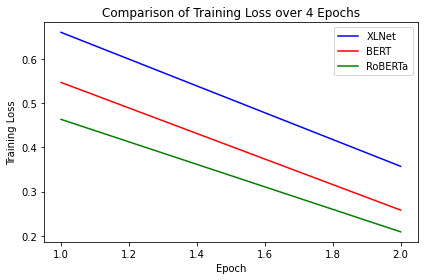

In [ ]:
#compare training loss of 3 models
epochs = [1, 2]

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()

ax.plot(epochs, xlnet_stats['Training Loss'], color='blue', label='XLNet')
ax.plot(epochs, bert_stats['Training Loss'], color='red', label='BERT')
ax.plot(epochs, roberta_stats['Training Loss'], color='green', label='RoBERTa')

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.legend()

ax.set_title('Comparison of Training Loss over 4 Epochs')
fig.tight_layout()

plt.show()


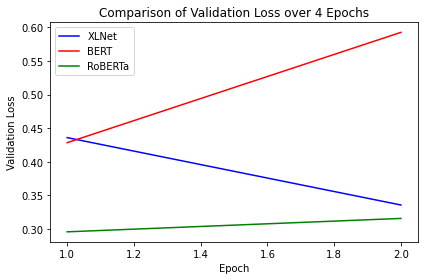

In [ ]:
#compare training loss of 3 models
epochs = [1, 2]

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()

ax.plot(epochs, xlnet_stats['Valid. Loss'], color='blue', label='XLNet')
ax.plot(epochs, bert_stats['Valid. Loss'], color='red', label='BERT')
ax.plot(epochs, roberta_stats['Valid. Loss'], color='green', label='RoBERTa')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.legend()

ax.set_title('Comparison of Validation Loss over 4 Epochs')
fig.tight_layout()

plt.show()


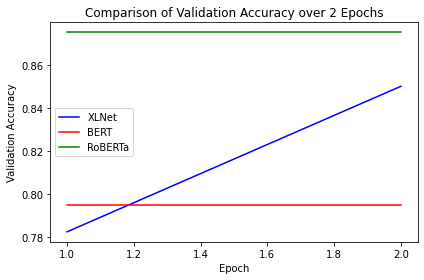

In [ ]:
#compare valid accur of 3 models
epochs = [1, 2]

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots()

ax.plot(epochs, xlnet_stats['Valid. Accur.'], color='blue', label='XLNet')
ax.plot(epochs, bert_stats['Valid. Accur.'], color='red', label='BERT')
ax.plot(epochs, roberta_stats['Valid. Accur.'], color='green', label='RoBERTa')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.legend()

ax.set_title('Comparison of Validation Accuracy over 2 Epochs')
fig.tight_layout()

plt.show()


We see that after 2 epochs, the validation loss is increasing which means that the model is overfitted. So we will choose number of epochs = 2 and we will focus on RoBERTa, since it gives the best performance at epochs 2.

### 10. Detalied Evaluation on Test data

In this scenario I shall pickup the validation dataset which was eariler created and shall use it for prediction. The features have already been created on the data so I would just use them for evaluation of our model as well

In [ ]:
# Load the dataset into a pandas dataframe.
df  = train_df.iloc[sentence_ids_list_valid,]

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 400



/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
roberta_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 400 test sentences...
    DONE.


In [ ]:
# print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
test_df = pd.read_json('./test_set.json')
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

Number of training sentences: 4,000



In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

sentences = test_df.text.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 360,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 16
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,000



<ipython-input-42-8c8b169d3ad7>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
roberta_model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
#   b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = roberta_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')


Predicting labels for 4,000 test sentences...
    DONE.


In [ ]:
# Flatten the predictions list
predictions = np.concatenate(predictions, axis=0)
print('Shape of predictions:', predictions.shape)

Shape of predictions: (4000, 2)


In [ ]:
print(predictions[1])

[ 0.41989496 -0.192219  ]


In [ ]:
from scipy.special import softmax

# Apply softmax to the logits to convert them into probabilities
probs = softmax(predictions, axis=1)

# Convert the probabilities into binary predictions by choosing the class with the highest probability
binary_preds = np.argmax(probs, axis=1)

# Print the first 10 binary predictions
print(binary_preds)

[0 0 1 ... 1 0 0]


In [ ]:
import csv
# Write predictions to a file
with open("submission.csv", "w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','label'])
    for i, row in enumerate(binary_preds):
        csv_out.writerow([i, row])